In [1]:
!pip install --quiet timm split-folders


In [2]:
import pandas as pd
import splitfolders
import cv2, glob
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


## Split train data to train & Validation

In [4]:
data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(data_dir, output="dataa",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [03:53, 96.19 files/s] 


## Display Images

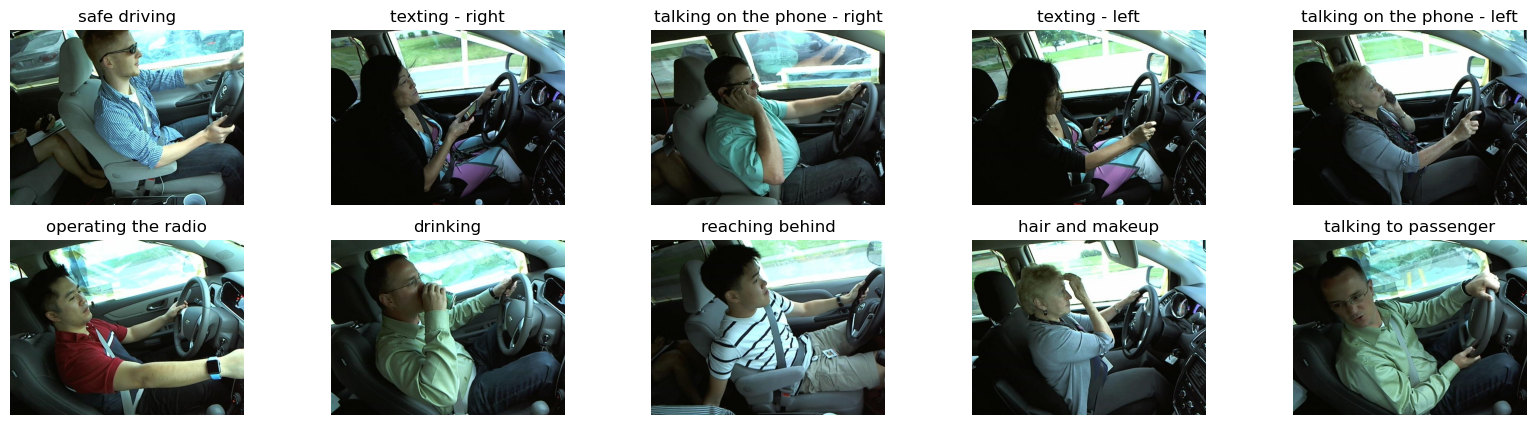

In [5]:
state = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN']

def Display(path, Class=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if Class == None:
        plt.figure()
        plt.title(state[10])
        plt.imshow(img)
        plt.axis("off")
        # print(img.shape)
    else:
        plt.subplot(2, 5, Class+1)
        plt.title(state[Class])
        plt.imshow(img)
        plt.axis("off")

plt.figure(figsize=(20, 5))
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg", 0)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1/img_100021.jpg", 1)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2/img_100029.jpg", 2)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/img_100006.jpg", 3)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4/img_100225.jpg", 4)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_10000.jpg", 5)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6/img_100036.jpg", 6)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7/img_100057.jpg", 7)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_100015.jpg", 8)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9/img_100090.jpg", 9)

In [6]:
# model define
from typing import Any, Dict, Optional, Tuple, List

import os
import subprocess
import torch
import timm
import json

import torchvision
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F


from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix, MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import io
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class IntHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        text = plt.matplotlib.text.Text(x0, y0, str(orig_handle))
        handlebox.add_artist(text)
        return text


class LitResnet(pl.LightningModule):
    def __init__(self, num_classes=6, model_name='resnet18', optim_name="SGD", lr=0.05):
        super().__init__()

        self.num_classes = num_classes
        self.save_hyperparameters()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

        self.lr = lr
        # configure optimizer
        if optim_name == "ADAM":
            self.optim_name = torch.optim.Adam
        if optim_name == "SGD":
            self.optim_name = torch.optim.SGD
        if optim_name == "RMS":
            self.optim_name = torch.optim.RMSprop

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=self.num_classes)

        # some other metrics to be logged
        self.f1_score = F1Score(task="multiclass", num_classes=self.num_classes)
        self.precision_score = Precision(task="multiclass", average='macro', num_classes=self.num_classes)
        self.recall_score = Recall(task="multiclass", average='macro', num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)
    
    
    def step(self, batch: Any):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)

        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()` below
        # remember to always return loss from `training_step()` or backpropagation will fail!
        return {"loss": loss, "preds": preds, "targets": targets}

    def training_epoch_end(self, outputs: List[Any]):
        # `outputs` is a list of dicts returned from `training_step()`
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.f1_score(preds, targets)
        self.precision_score(preds, targets)
        self.recall_score(preds, targets)
        self.log("val/loss", self.val_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=True, on_epoch=True, prog_bar=False)
        self.log("val/f1", self.val_acc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/precision", self.precision_score, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/recall", self.recall_score, on_step=False, on_epoch=True, prog_bar=False)
        return {"loss": loss, "preds": preds, "targets": targets}

    def validation_epoch_end(self, outs: List[Any]):
        tb = self.logger.experiment  # noqa

        outputs = torch.cat([tmp['preds'] for tmp in outs])
        labels = torch.cat([tmp['targets'] for tmp in outs])

        confusion = ConfusionMatrix(task="multiclass", num_classes=self.num_classes).to(device)
        confusion(outputs, labels)
        computed_confusion = confusion.compute().detach().cpu().numpy().astype(int)

        # confusion matrix
        df_cm = pd.DataFrame(
            computed_confusion,
            index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            columns= ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sn.set(font_scale=1.2)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        ax.legend(
            [0, 1, 2, 3, 4, 5],
            ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
            handler_map={int: IntHandler()},
            loc='upper left',
            bbox_to_anchor=(1.2, 1)
        )
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        tb.add_image("val_confusion_matrix", im, global_step=self.current_epoch)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

        return {"loss": loss, "preds": preds, "targets": targets}

    def test_epoch_end(self, outputs: List[Any]):
        pass

    def configure_optimizers(self):
        optimizer = self.optim_name(
            self.parameters(),
            lr=self.lr,
        )
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size  = 10 , gamma = 0.5)
        return {
            "optimizer":optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train/loss",
                
            }
          }

In [7]:
from typing import Any, Dict, Optional

import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset


class IntelClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_data_dir: str = "data/",
        test_data_dir: str = "data/",
        batch_size: int = 256,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        
        self.train_data_dir = train_data_dir
        self.test_data_dir = test_data_dir

        ######################
        # data transformations
        ######################
        # References: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
        

        self.transforms1 = T.RandomApply(
            [
                T.RandomRotation(degrees=(0, 70)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=(0.1, 0.6), contrast=1, saturation=0, hue=0.3),
                T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                T.RandomHorizontalFlip(p=0.3),
            ], 
            p=0.3
        )
        self.transforms = T.Compose([
                self.transforms1,
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.data_train: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self):
        return len(self.data_train.classes)
    
    @property
    def classes(self):
        return self.data_train.classes

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_test:
            trainset = ImageFolder(self.train_data_dir, transform=self.transforms)
            testset = ImageFolder(self.test_data_dir, transform=self.transforms)
            
            self.data_train, self.data_test = trainset, testset

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass



In [8]:
TRAIN_DATA_PATH = '/kaggle/working/dataa/train'
TEST_DATA_PATH = '/kaggle/working/dataa/val'

batch_size = 128



:: Reading dataset ..
:: Classnames:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
:: Datamodule setup completed ..


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_c_rab2_256-a54bf36a.pth" to /root/.cache/torch/hub/checkpoints/regnetz_c_rab2_256-a54bf36a.pth


:: Training ...


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Saving Model Ckpt
:: Saving Scripted Model


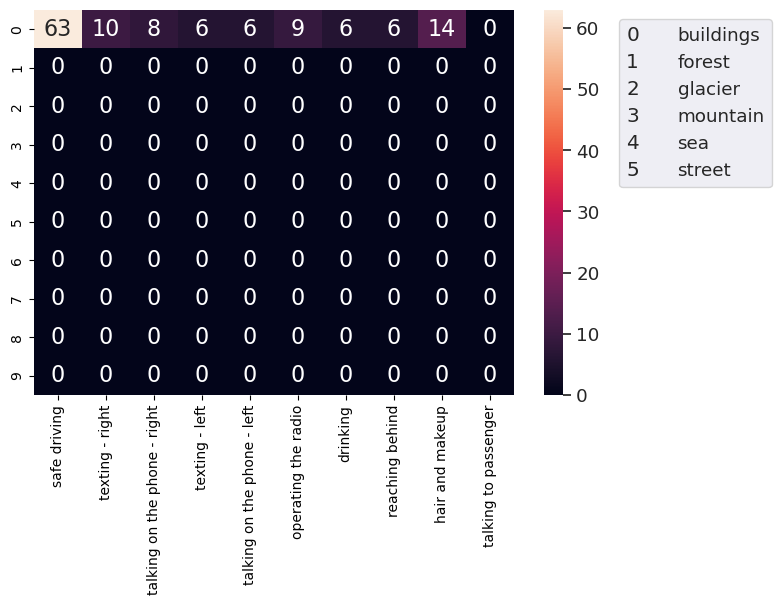

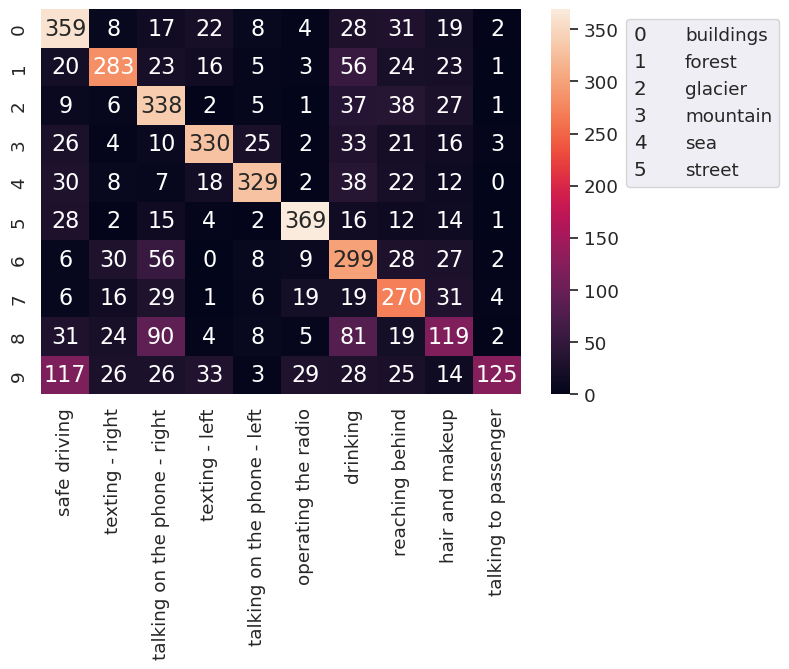

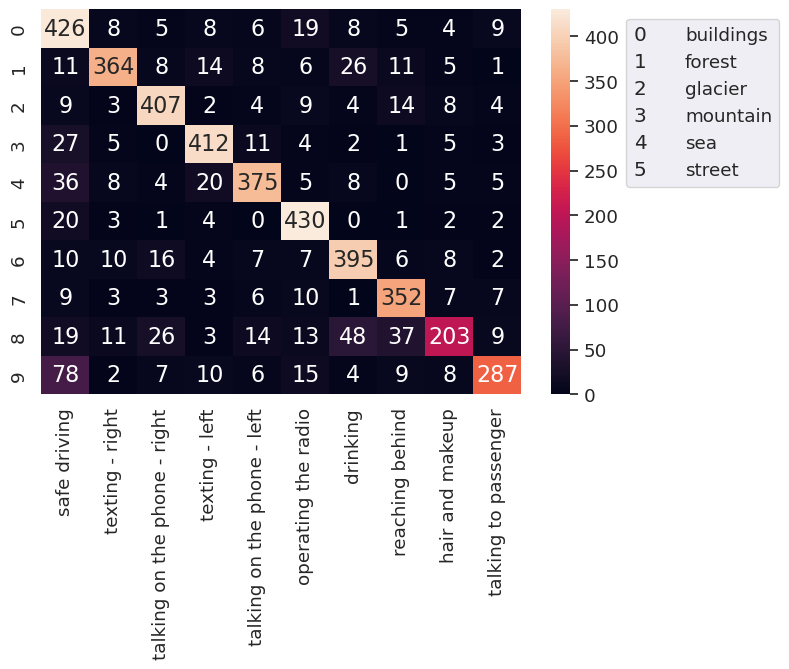

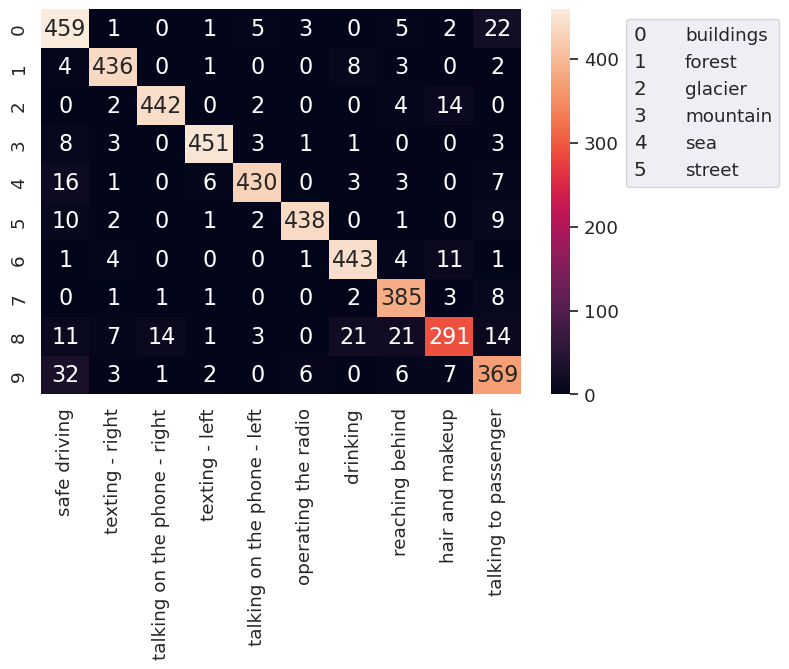

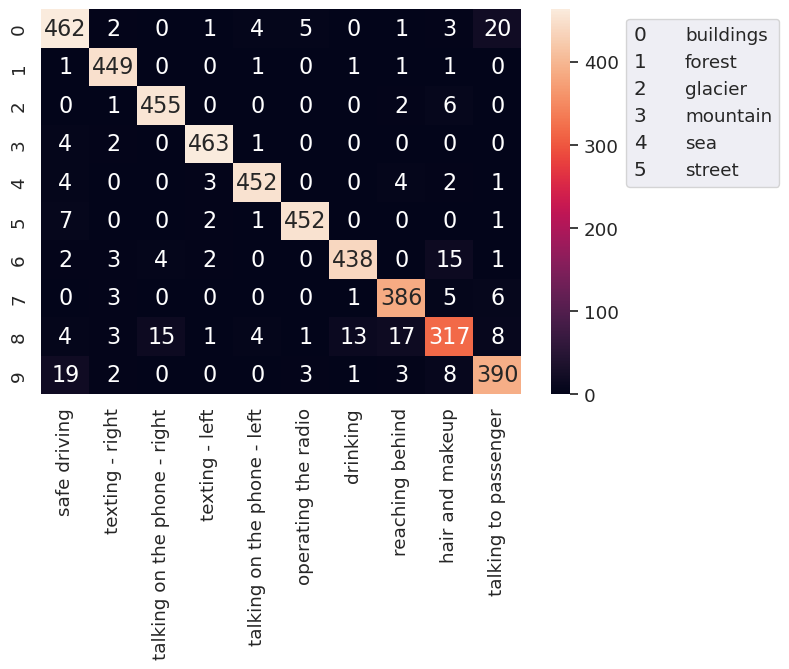

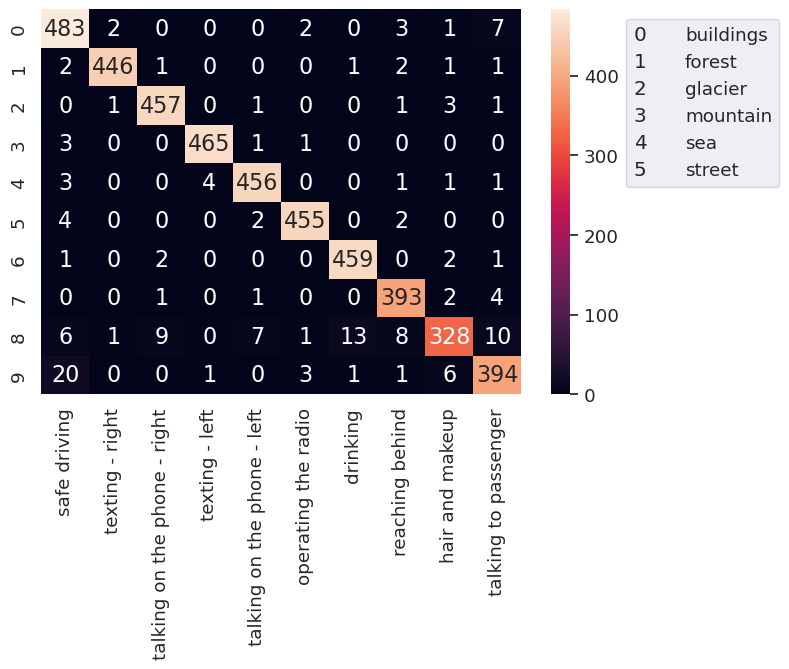

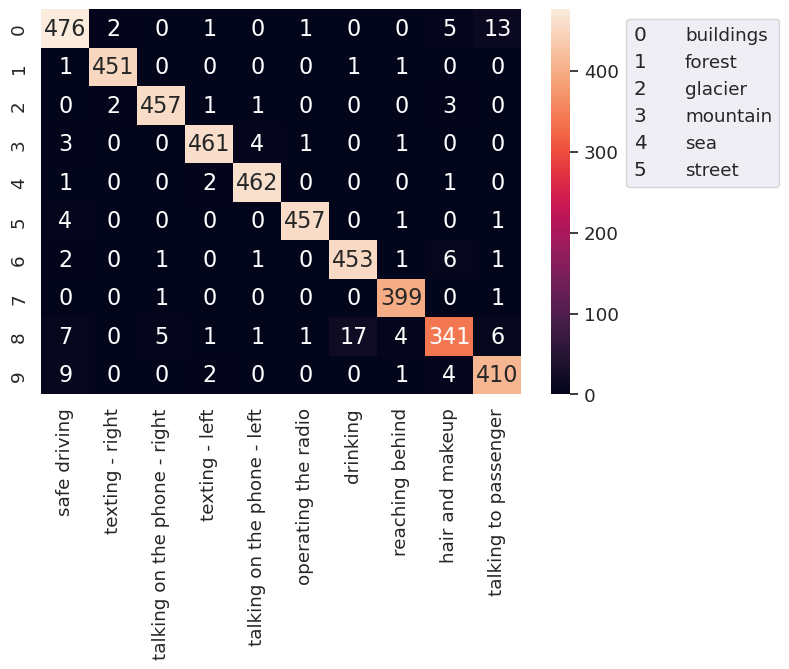

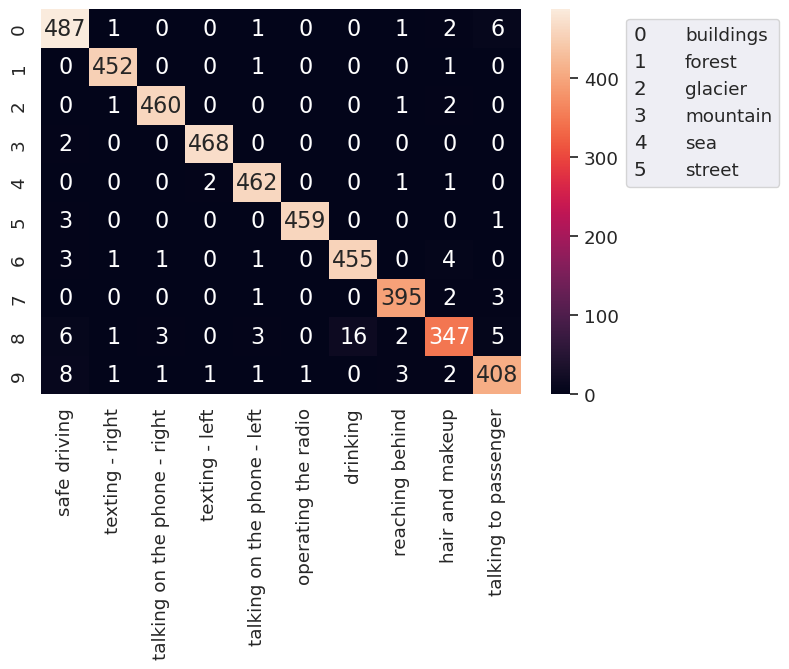

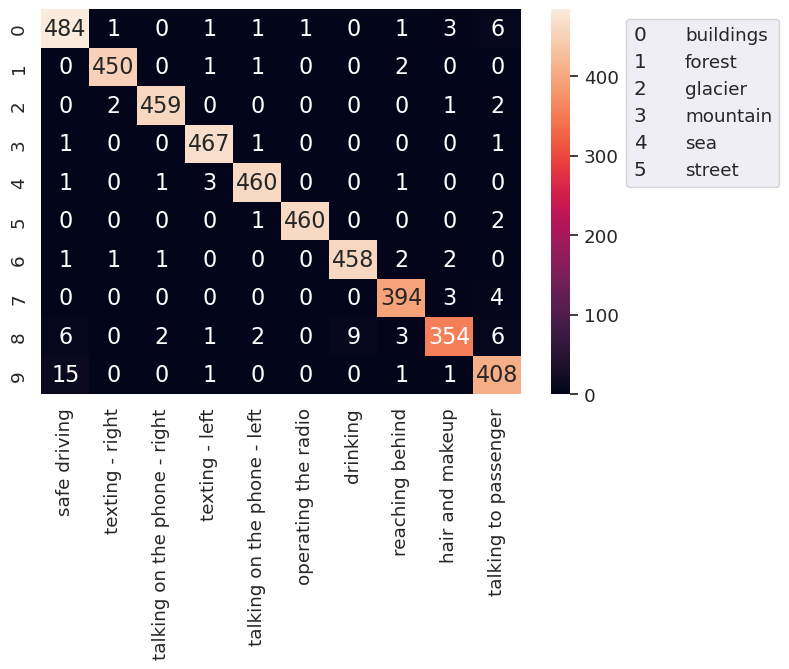

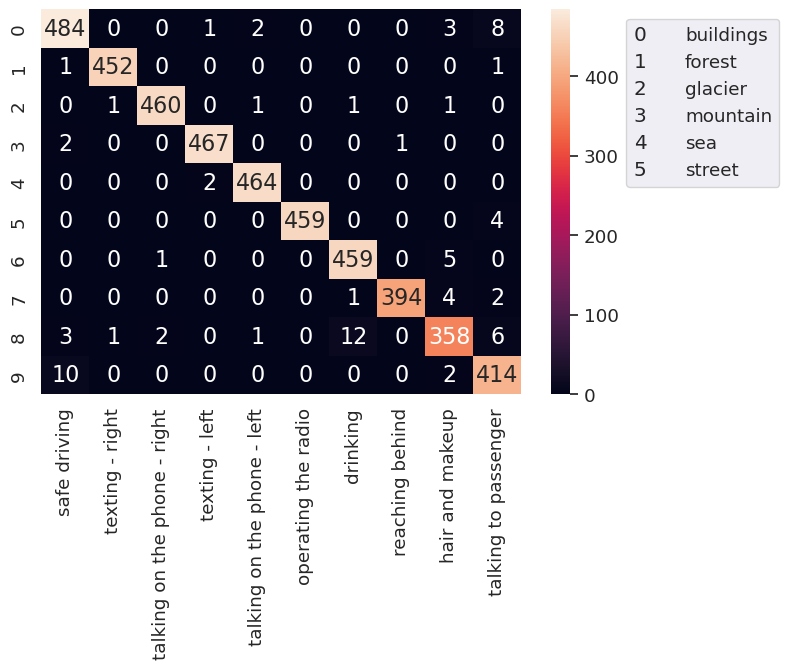

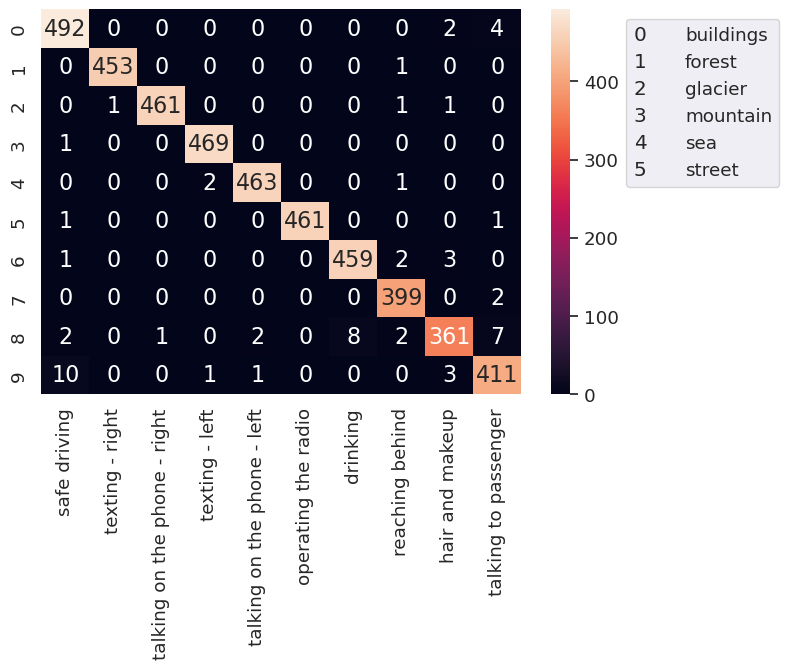

In [9]:
from typing import Any, Dict, Optional, Tuple

import os
import subprocess
import torch
import timm
import json

import pytorch_lightning as pl
from pathlib import Path
from torchvision.datasets import ImageFolder
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


model_name = "regnetz_c16"
optimizer_name = "ADAM"
learning_rate = 0.000012
batch_size = 64


 

def train(model, datamodule):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="output")
    early_stop_callback = EarlyStopping(monitor="val/acc", min_delta=0.00, patience=3, verbose=False, mode="max")
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",
        callbacks=[early_stop_callback],
        logger=[tb_logger]
    )
    hyperparameters = dict(model_name=model_name, optimizer_name=optimizer_name, learning_rate=learning_rate)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule)
    
    return trainer


def save_scripted_model(model):
    script = model.to_torchscript()

    # save for use in production environment
    torch.jit.save(script,"model.scripted.pt")
    
    
def save_model(model):
    torch.save(model.state_dict(), "model.pt")


def save_last_ckpt(trainer):
    trainer.save_checkpoint("last.ckpt")


if __name__ == '__main__':
    test_dir = "/kaggle/working/dataa/val"
    train_dir = "/kaggle/working/dataa/train"
    
    # Reading dataset
    print(":: Reading dataset ..")
    img_dset = ImageFolder(train_dir)
    
    print(":: Classnames: ", img_dset.classes)
    
    
    datamodule = IntelClassificationDataModule(train_data_dir=train_dir, test_data_dir=test_dir,
                                               batch_size=batch_size,num_workers=4)
    datamodule.setup()
    
    print(":: Datamodule setup completed ..")
    model = LitResnet(num_classes=datamodule.num_classes, model_name=model_name, optim_name=optimizer_name,
                      lr=learning_rate)
        
    print(":: Training ...")
    trainer = train(model, datamodule)

    print(":: Saving Model Ckpt")
    save_last_ckpt(trainer)
    
    # set to evaluation model before scripting
    print(":: Saving Scripted Model")
    save_model(model)
